In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mudata as mu 
import scanpy as sc

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from collections import defaultdict
import json


In [3]:
import sys 
sys.path.append('../src')
from spaceoracle import SpaceOracle

2024-10-08 17:24:02.141700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load data & choose experiment

In [4]:
from utils import h5mu_to_h5ad

mdata = mu.read_h5mu('../data/kidney/mdata_3.h5mu')
adata = h5mu_to_h5ad(mdata)


In [5]:
chips = np.unique(adata.obs['chip'])
chips

array(['275', '276', '281', '285', '286', '319', '405', '408', '409',
       '410', '413'], dtype=object)

In [6]:
from utils import process_adata

experiment = '275'
adata = adata[adata.obs['chip'] == experiment]

adata = process_adata(adata, n_top_genes=3000, mouse=True)
adata

AnnData object with n_obs × n_vars = 7166 × 3000
    obs: 'batch', 'rxn', 'n_counts', '%mito_ms', 'leiden', 'leiden_R', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dimred_params', 'leiden', 'log1p', 'neighbors', 'pca', 'plt', 'rank_genes_groups', 'umap', 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_reordered', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'dim', 'npc-l1p', 'raw_count'
    obsp: 'connectivities', 'distances'

In [7]:
ct_counts = adata.obs['ct2'].value_counts()
ct_counts

ct2
Mac                             5196
DC                               355
T                                336
B                                303
Granulocyte                      253
Endothelial_DVR                  155
Endothelial_Anti-Apoptosis       154
Endothelial_Capilary             106
Epithelial_Collecting_Duct       101
Epithelial_Henle_Loop             66
Mono                              50
Pericyte                          26
Epithelial_Nephron                17
NK                                14
RBC                               11
Endothelial_Mmrn1+                 6
Epithelial_Pelvis                  5
VSMC                               4
Fibroblast                         3
Epithelial_Transitional            3
Neuronal_Schwann_Cell              1
Epithelial_Convoluted_Tubule       1
Name: count, dtype: int64

In [8]:
from utils import filter_clusters

low_count_clusters = [ct for ct, count in zip(ct_counts.index, ct_counts) if count < 100]
adata = filter_clusters(adata, c=low_count_clusters, annot = 'ct2')
adata

AnnData object with n_obs × n_vars = 6959 × 3000
    obs: 'batch', 'rxn', 'n_counts', '%mito_ms', 'leiden', 'leiden_R', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dimred_params', 'leiden', 'log1p', 'neighbors', 'pca', 'plt', 'rank_genes_groups', 'umap', 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_reordered', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'dim', 'npc-l1p', 'raw_count'
    obsp: 'connectivities', 'distances'

In [114]:
X = adata.obsm['spatial'][:, 0]
Y = adata.obsm['spatial'][:, 1]
Z = []

occurrence = defaultdict(int)
for x, y in zip(X, Y):
    height = occurrence[(x,y)]
    occurrence[(x,y)] += 1
    Z.append(height)


In [10]:
ncells = X.shape[0]

fig = px.scatter_3d(
    x=X, y=Y, z=Z,
    color=adata.obs['ct2'],
    )

fig.update_traces(
    marker=dict(size=2), 
    line=dict(width=2, color='black')
    )

fig.show()


In [132]:
cell_type_mapping = {cluster: i for i, cluster in enumerate(np.unique(adata.obs['ct2']))}
adata.obs['cluster'] = [cell_type_mapping[cluster] for cluster in adata.obs['ct2']]
adata.obs['cluster'] = adata.obs['cluster'].astype('category')

reverse = {i : cluster for cluster, i in cell_type_mapping.items()}
with open('../data/kidney/celltype_assign.json', 'w') as f:
    json.dump(reverse, f, indent=4)

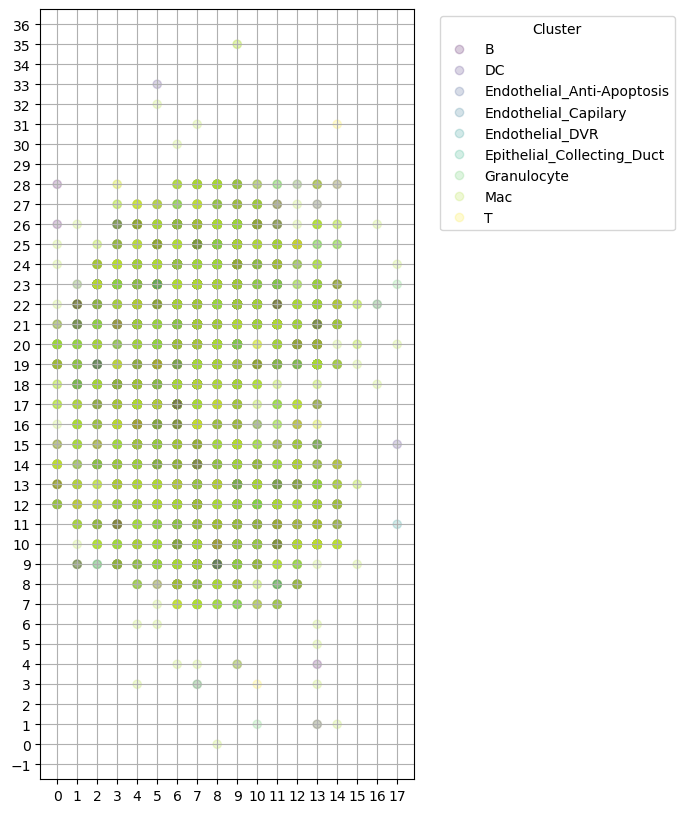

In [136]:
plt.figure(figsize=(10,10))
scatter = plt.scatter(X, Y, c=adata.obs['cluster'], alpha=0.2, cmap='viridis')

handles, labels = scatter.legend_elements()
labels = [reverse[label] for label in np.unique(adata.obs['cluster'])]
plt.legend(handles, labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, which='both')  # which='both' shows major and minor grid lines
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))

plt.show()

### Get CO GRN

In [12]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180

2024-10-04 18:52:50.242902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 18:52:50.493121: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 18:52:50.530825: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 18:52:50.946511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the a

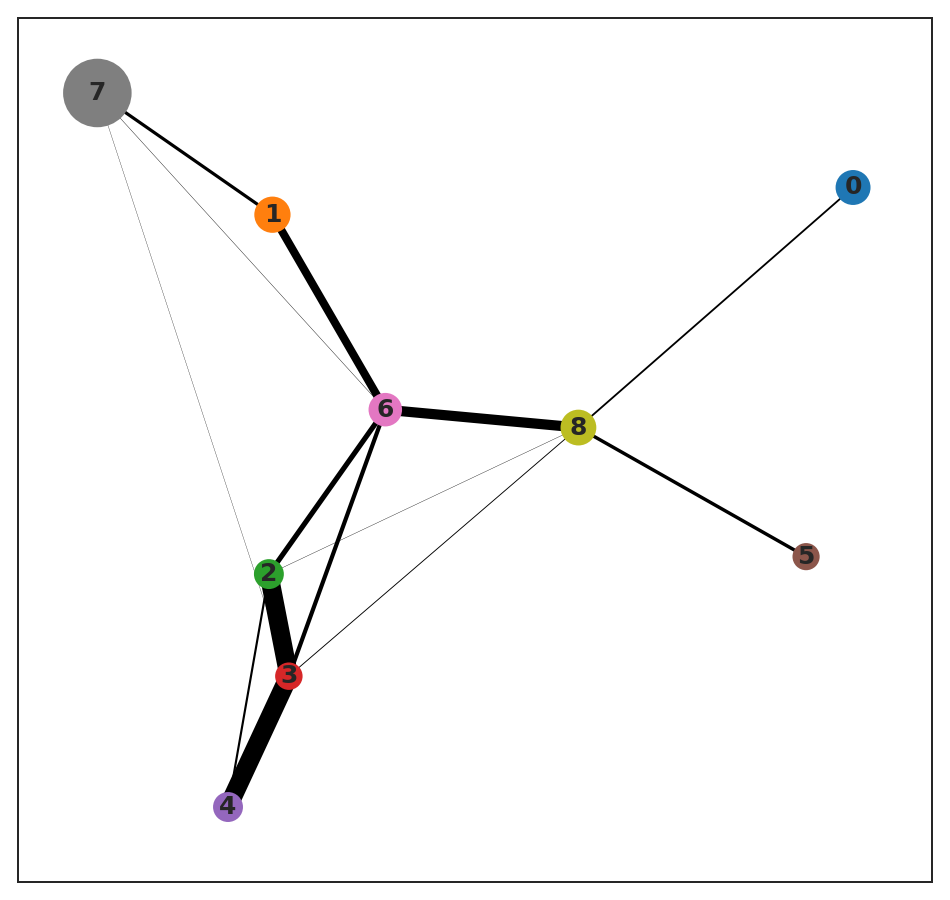

CPU times: user 30.2 s, sys: 8.02 s, total: 38.2 s
Wall time: 40.9 s


In [13]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')
sc.tl.paga(adata, groups='cluster')
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

In [15]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)

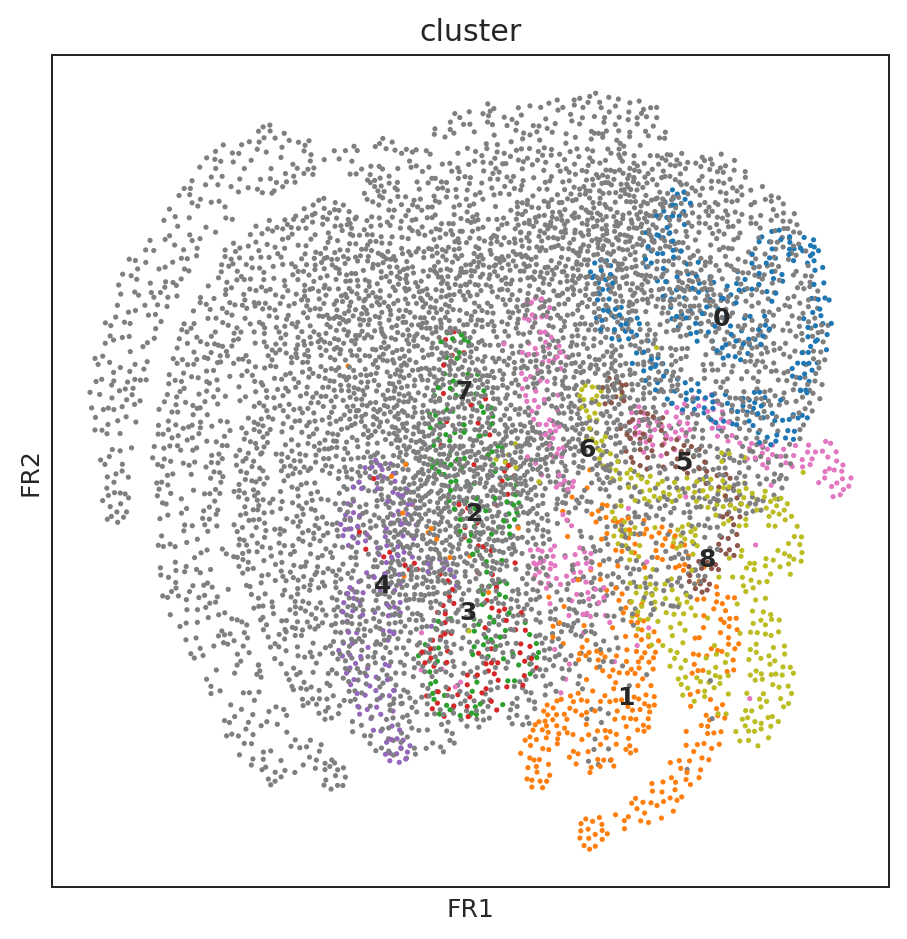

In [16]:
sc.pl.draw_graph(adata, color='cluster', legend_loc='on data')

In [17]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cluster",
    embedding_name="X_draw_graph_fr"
)

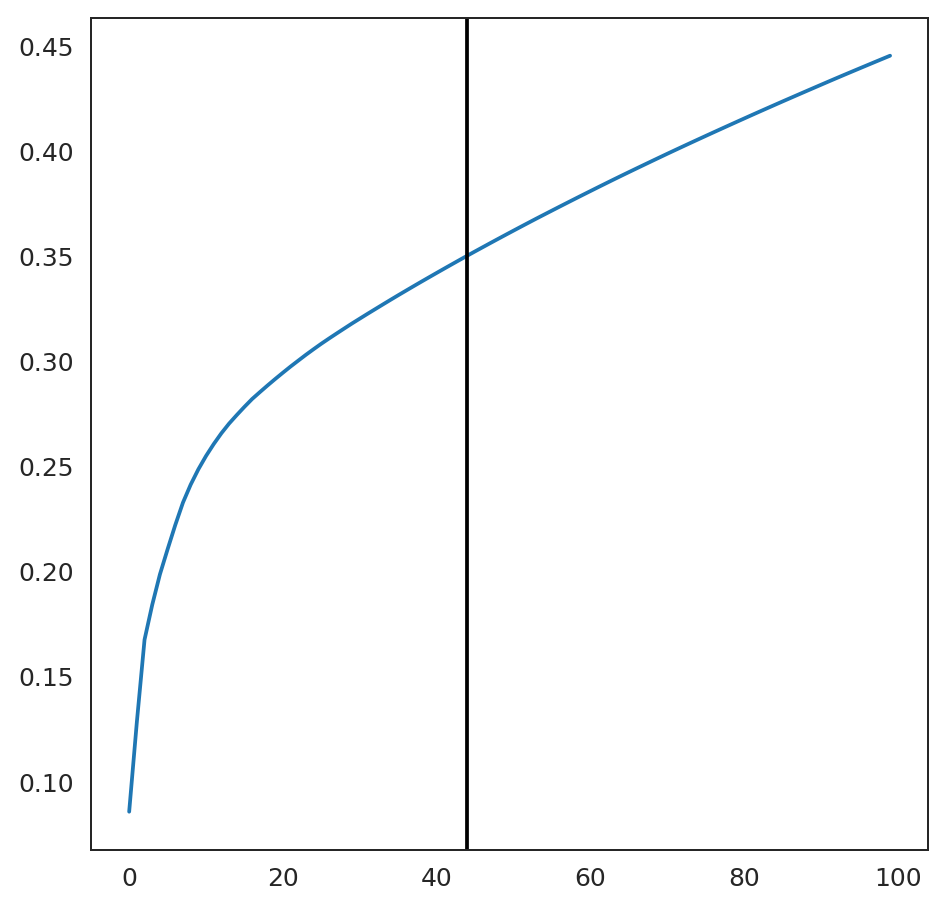

44


In [18]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [19]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :6959
Auto-selected k is :173


In [20]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [20]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [21]:
adata.obsm['X_pca'].shape

(6959, 50)

In [22]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cluster", 
    alpha=10,
    verbose_level=10, 
    # test_mode=True,
    # n_jobs=8
)

  0%|          | 0/9 [00:00<?, ?it/s]

Inferring GRN for 0...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 1...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 2...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 3...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 4...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 5...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 6...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 7...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 8...


  0%|          | 0/2295 [00:00<?, ?it/s]

CPU times: user 25min 26s, sys: 6.41 s, total: 25min 33s
Wall time: 25min 58s


In [23]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [24]:
import pickle

with open('../data/kidney/celloracle_links.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)


In [25]:
with open('../data/kidney/celloracle_coefs.pkl', 'wb') as f:
    pickle.dump(oracle.coef_matrix_per_cluster, f)

### Run COMMOT

In [12]:
import commot as ct
df_ligrec = ct.pp.ligand_receptor_database(database='CellChat', species='mouse')
df_ligrec.shape


2024-10-05 13:11:17.598724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 13:11:17.818265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 13:11:17.898519: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 13:11:26.642826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(1209, 4)

In [13]:
ct.tl.spatial_communication(adata,
    database_name='user_database', df_ligrec=df_ligrec, dis_thr=500, heteromeric=True, pathway_sum=True)

### Train BayesPixLR

In [7]:
adata = sc.read_h5ad(".cache/kidney_275.h5ad")

In [8]:
import spaceoracle
from spaceoracle import SpaceOracle
from spaceoracle.models.estimators import device
from spaceoracle.models.probabilistic_estimators import ProbabilisticPixelAttention, ProbabilisticPixelModulators

In [9]:
np.max(adata.obsm['spatial']) - np.min(adata.obsm['spatial'])

35

In [10]:
spatial_dim = 35

spaceoracle.SpaceOracle.imbue_adata_with_space(
    adata=adata, annot='cluster', 
    spatial_dim=spatial_dim, in_place=True, 
    method='fast'
)

🌍️ Generating spatial 35x35 maps...


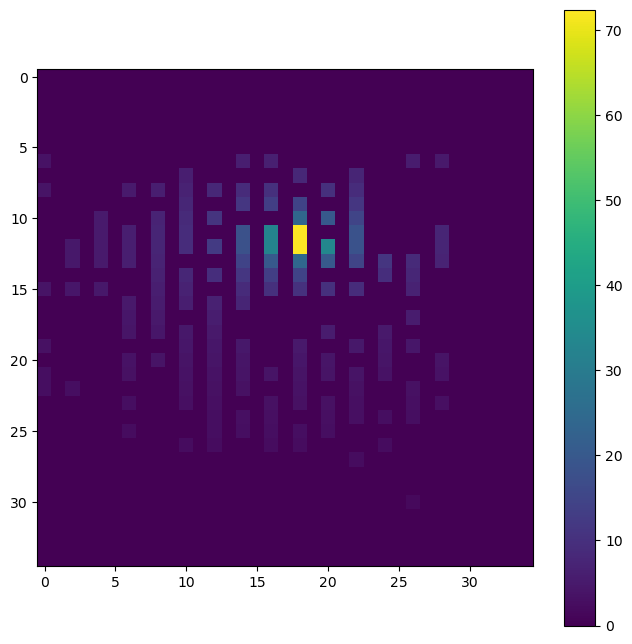

In [11]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.imshow(adata.obsm['spatial_maps'][1][0])
plt.colorbar()
plt.show()

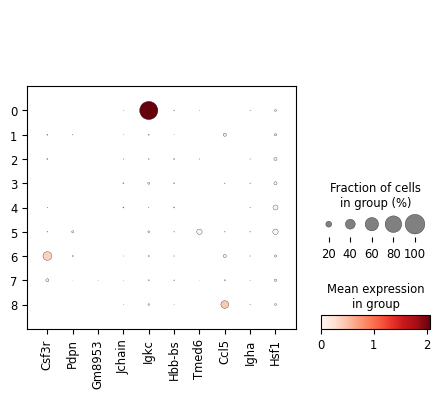

In [12]:
# adata.obs['cluster'] = adata.obs['cluster'].astype(int)

sc.pp.highly_variable_genes(adata, n_top_genes=10)
marker_genes = adata.var_names[adata.var['highly_variable']]

sc.pl.dotplot(adata, marker_genes, groupby='cluster')

In [13]:
target_gene = 'Cd74'
target_gene in adata.var_names

True

In [14]:
from utils import get_imputed

adata = get_imputed(adata, spatial_dim, annot='cluster')
adata

🌍️ Generating spatial 35x35 maps...


AnnData object with n_obs × n_vars = 6959 × 3000
    obs: 'batch', 'rxn', 'n_counts', '%mito_ms', 'leiden', 'leiden_R', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cluster'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'commot-user_database-info', 'dimred_params', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'plt', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_reordered', 'X_umap', 'commot-user_database-sum-receiver', 'commot-user_database-sum-sender',

In [15]:
from spaceoracle.tools.network import MouseKidneyRegulatoryNetwork
co_grn = MouseKidneyRegulatoryNetwork()

In [16]:
%%time
import pyro
pyro.clear_param_store()

estimator = ProbabilisticPixelModulators(
    adata, target_gene=target_gene, layer='imputed_count', 
    annot='cluster', co_grn=co_grn
    )

estimator.fit(
    annot='cluster', 
    max_epochs=10, 
    learning_rate=7e-4, 
    spatial_dim=spatial_dim,
    batch_size=512,
    alpha=0.4,
    cache=False
)

Fitting 9 models in parallel... with 9/64 cores
37 regulators + 122 ligands + 122 receptors


CPU times: user 42min 11s, sys: 4.77 s, total: 42min 16s
Wall time: 3min 20s


In [17]:
with open('../data/kidney/celltype_assign.json', 'rb') as f:
    celltype_labels = json.load(f)

celltype_labels = {int(c): label for c, label in celltype_labels.items()}
celltype_labels

{0: 'B',
 1: 'DC',
 2: 'Endothelial_Anti-Apoptosis',
 3: 'Endothelial_Capilary',
 4: 'Endothelial_DVR',
 5: 'Epithelial_Collecting_Duct',
 6: 'Granulocyte',
 7: 'Mac',
 8: 'T'}

<Axes: >

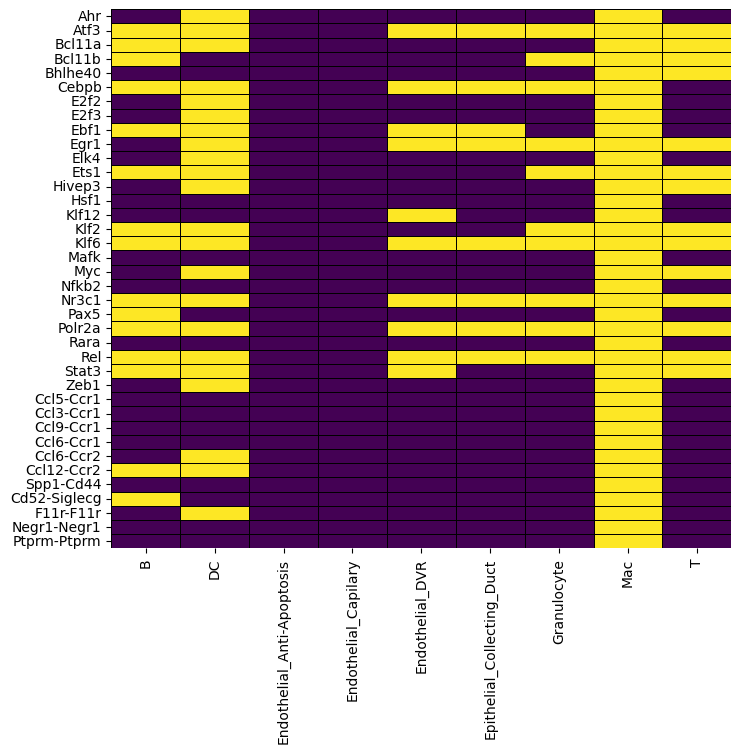

In [28]:
sig_df = estimator.is_real.loc[estimator.is_real.sum(1) > 0]
sig_df.rename(columns=celltype_labels, inplace=True)
sns.heatmap(sig_df, cmap='viridis', yticklabels=True, xticklabels=True, linewidths=0.5, linecolor='black', cbar=False)

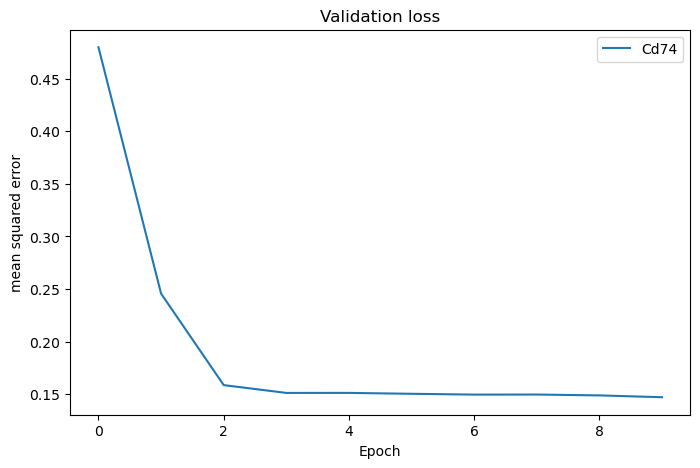

In [19]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 100
plt.plot(estimator.losses, label=target_gene)
plt.xlabel('Epoch')
plt.ylabel('mean squared error')
plt.title(f'Validation loss')
plt.legend()
plt.show()

In [20]:
import torch

device = torch.device('cuda')
from spaceoracle.tools.utils import gaussian_kernel_2d

from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

In [21]:
est = estimator
adata_train = estimator.adata

X = torch.from_numpy(adata_train.to_df(layer=est.layer)[est.regulators].values).float()
y = torch.from_numpy(adata_train.to_df(layer=est.layer)[est.target_gene].values).float()
cluster_labels = torch.from_numpy(np.array(adata_train.obs[est.annot])).long()

# Generate ligand-receptor data
xy = np.array(adata_train.obsm['spatial']).copy()
ligX = adata_train.to_df(layer=est.layer)[est.ligands].values
recpX = adata_train.to_df(layer=est.layer)[est.receptors].values

lr_exp = []
for i in range(len(xy)):
    w = gaussian_kernel_2d(xy[i], xy, radius=200)

    ligand_exp = (ligX.T * w).T
    receptor_exp = recpX[i]
    lr_exp.append((ligand_exp * receptor_exp).mean(axis=0))

lr_exp = torch.from_numpy(np.stack(lr_exp, axis=0)).float()

X = torch.cat([X, lr_exp], dim=1)

with torch.no_grad():
    betas_ = est.get_betas(
        spatial_maps=np.array(adata_train.obsm['spatial_maps']),
        labels=np.array(adata_train.obs['cluster']),
    )

    y_pred = est.predict_y(
        est.model, 
        torch.from_numpy(betas_).to(device), 
        torch.from_numpy(np.array(adata_train.obs['cluster'])).to(device),
        X.to(device)).cpu().numpy()

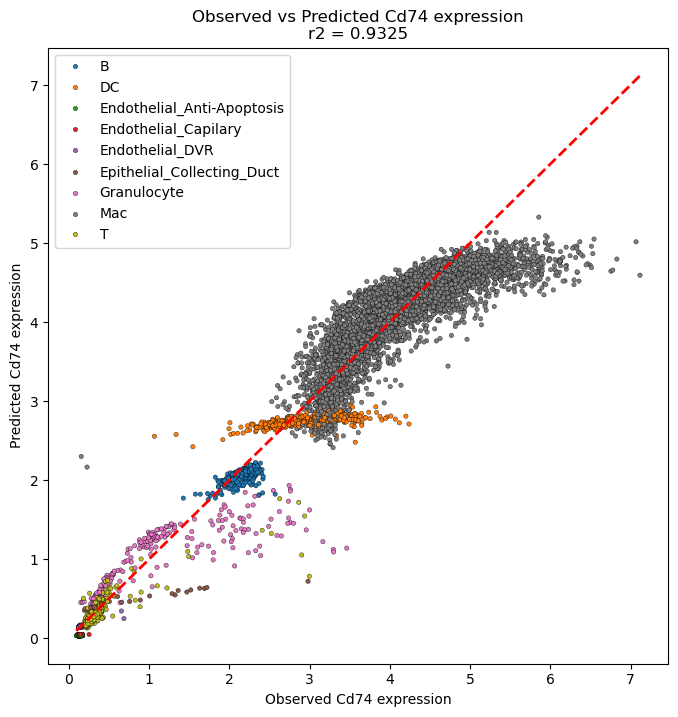

In [22]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams['figure.dpi'] = 100

y = adata_train.to_df(layer=est.layer)[[target_gene]]

sns.scatterplot(
    x=y.values.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    # c=adata_train.obs['cluster'].values[:], 
    hue=adata_train.obs['ct2'].values[:],  # Use 'hue' for coloring by cluster
    palette='tab10',
    edgecolor='black', linewidth=0.25)

plt.legend()


plt.xlabel(f'Observed {target_gene} expression')
plt.ylabel(f'Predicted {target_gene} expression')
plt.title(f'Observed vs Predicted {target_gene} expression\n'
    f'r2 = {r2_score(y.values.reshape(-1), y_pred.reshape(-1)):.4f}')
# plt.xlim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)
# plt.ylim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)
# Add x=y line

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.show()

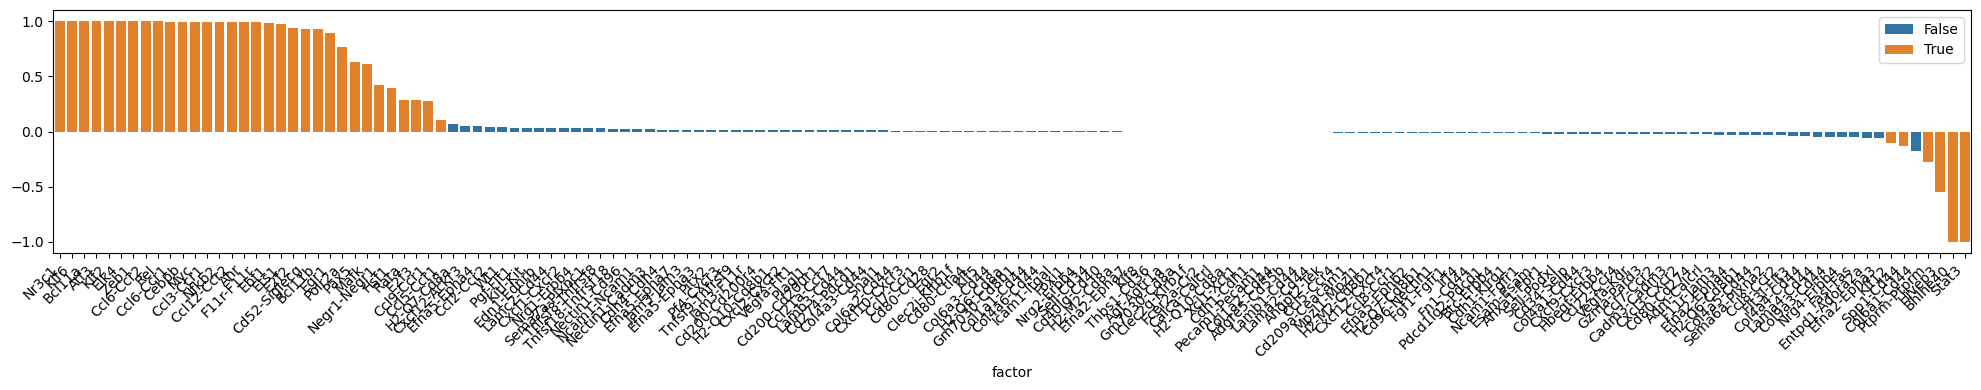

In [23]:
df = pd.DataFrame(betas_, columns=['intercept']+est.regulators+list(est.lr['pairs']))

plt.rcParams['figure.figsize'] = [20, 4]
dfx = df.drop(['intercept'], axis=1).mean()[
    df.drop(['intercept'], axis=1).mean().abs() > 0.001].sort_values(ascending=False)

sns.barplot(
    x=dfx.index, 
    y=dfx.values, 
    hue=estimator.is_real.loc[dfx.index].sum(1) > 0
)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.xlabel('factor')
plt.legend()

In [29]:
'Pax5' in estimator.regulators

True

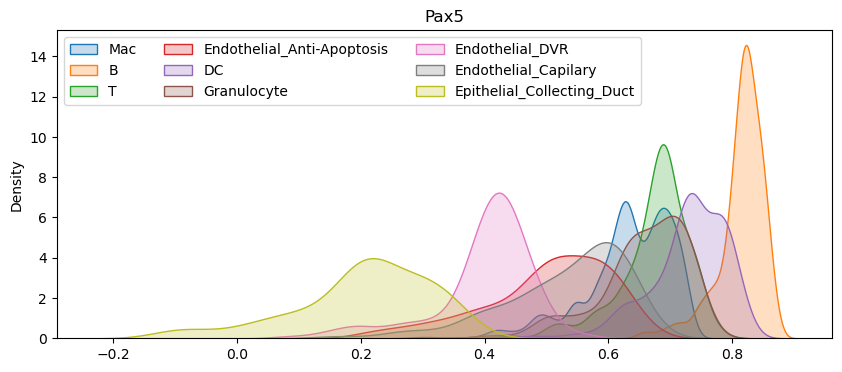

In [24]:
plt.rcParams['figure.figsize'] = [10, 4]
# df = pd.DataFrame(betas_, columns=['intercept']+est.regulators)

# for celltype in adata_train.obs['rctd_celltypes'].unique():
#     sns.kdeplot(
#         df['Pax5'].values[adata_train.obs['rctd_celltypes'] == celltype], 
#         shade=True, label=celltype)
# plt.title('Pax5')
# plt.legend(ncols=3)
# plt.show()

# df = pd.DataFrame(betas, columns=['intercept']+est.regulators)

for celltype in adata_train.obs['ct2'].unique():
    sns.kdeplot(
        df['Pax5'].values[adata_train.obs['ct2'] == celltype], 
        shade=True, label=celltype)
plt.title('Pax5')
plt.legend(ncols=3)
plt.show()

### Visualizations

In [4]:
from spaceoracle.oracles import SpaceOracle
from spaceoracle.tools.network import MouseKidneyRegulatoryNetwork

co_grn = MouseKidneyRegulatoryNetwork()
adata = sc.read_h5ad('.cache/kidney_chip275_dim35')
spatial_dim=35

In [5]:
so = SpaceOracle(
    adata=adata,
    annot='cluster', 
    max_epochs=5, 
    learning_rate=7e-4, 
    spatial_dim=spatial_dim,
    batch_size=256,
    rotate_maps=True,
    alpha=0.4,
    co_grn=co_grn
)

In [7]:
so.run()

Fitting 9 models in parallel... with 9/64 cores


2024-10-07 12:24:45.198423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-07 12:24:46.001637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-07 12:24:46.192871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-07 12:24:48.289693: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-07 12:24:49.021031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-07 12:24:49.435897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-07 12:24:49.576469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-07 12:24:49.796486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-

49 regulators + 122 ligands + 122 receptors
Fitting 9 models in parallel... with 9/64 cores
7 regulators + 122 ligands + 122 receptors
Fitting 9 models in parallel... with 9/64 cores
22 regulators + 122 ligands + 122 receptors
Fitting 9 models in parallel... with 9/64 cores
49 regulators + 122 ligands + 122 receptors
Fitting 9 models in parallel... with 9/64 cores
80 regulators + 122 ligands + 122 receptors
Fitting 9 models in parallel... with 9/64 cores
16 regulators + 122 ligands + 122 receptors
Fitting 9 models in parallel... with 9/64 cores
22 regulators + 122 ligands + 122 receptors
Fitting 9 models in parallel... with 9/64 cores
11 regulators + 122 ligands + 122 receptors
Fitting 9 models in parallel... with 9/64 cores
43 regulators + 122 ligands + 122 receptors
Fitting 9 models in parallel... with 9/64 cores
69 regulators + 122 ligands + 122 receptors


In [6]:
import pickle 

with open('beta_dict_kidney.pickle', 'rb') as handle:
    so.beta_dict = pickle.load(handle)

In [7]:
goi = 'Ccl5'
goi in so.adata.var_names

True

In [8]:
so.simulate_shift(perturb_condition={goi: 0}, n_jobs=15)

warning! hard-coded radius=200


In [12]:
# so.embedding_name = 'X_draw_graph_fr'
# so.embedding = so.adata.obsm['X_draw_graph_fr']

so.embedding_name = 'spatial'
so.embedding = so.adata.obsm['spatial']

# so.embedding_name = 'X_umap'
# so.embedding = so.adata.obsm['X_umap']

In [14]:
from spaceoracle.applications import Pseudotime_calculator

pt = Pseudotime_calculator(adata=so.adata,
                           obsm_key=so.embedding_name, # Dimensional reduction data name
                           cluster_column_name=so.annot # Clustering data name
                           )

69


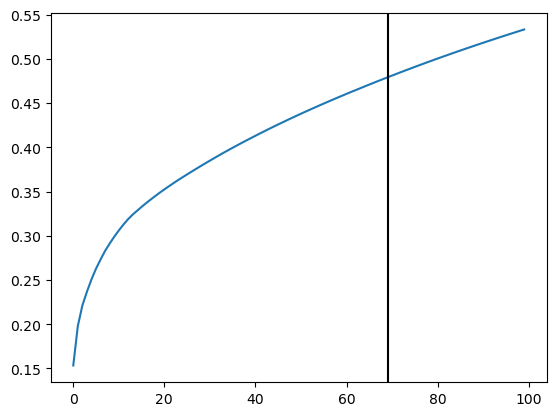

In [17]:
# Select important PCs
so.pca = so.get_PCA(so.adata)
plt.plot(np.cumsum(so.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(so.pca.explained_variance_ratio_))>0.002))[0][0]
print(n_comps)

plt.axvline(n_comps, c="k")
plt.show()
n_comps = min(n_comps, 50)

In [18]:
n_cell = so.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :6959
Auto-selected k is :173


In [ ]:
goi = 'Ccl5'
goi in so.adata.var_names

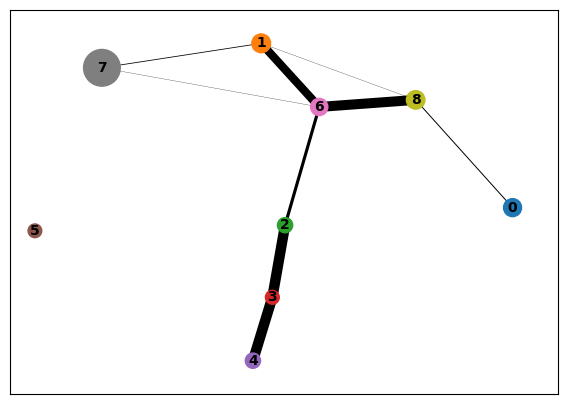

In [26]:
sc.pp.neighbors(so.adata, n_neighbors=15, n_pcs=20)
sc.tl.diffmap(so.adata)
sc.pp.neighbors(so.adata, n_neighbors=15, use_rep='X_diffmap')
sc.tl.paga(so.adata, groups='cluster')
sc.pl.paga(so.adata)

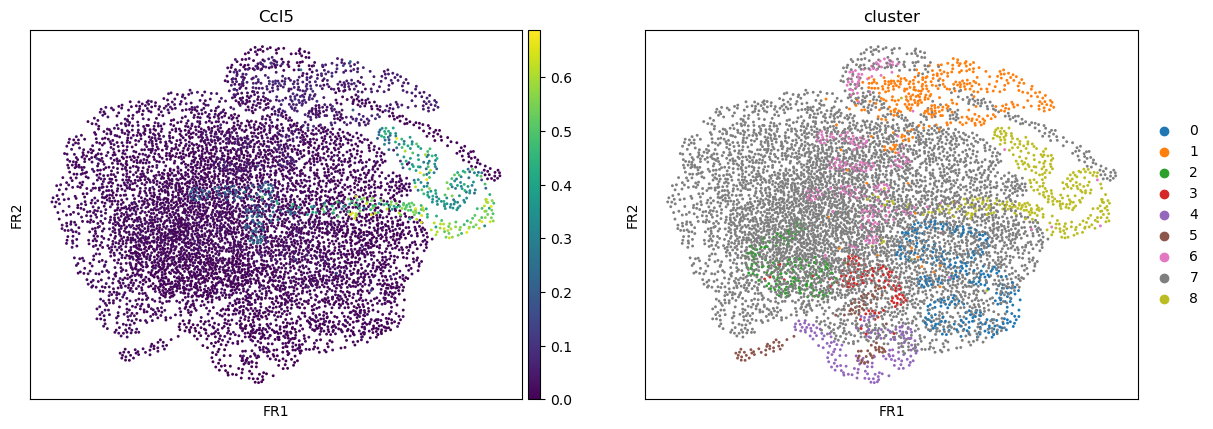

In [27]:
sc.tl.draw_graph(so.adata, init_pos='paga', random_state=123)
sc.pl.draw_graph(so.adata, color=[goi, so.annot],
                 layer="imputed_count", use_raw=False, cmap="viridis")

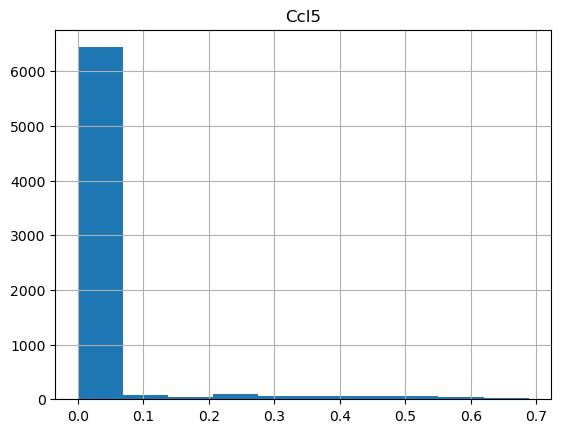

In [28]:
# Plot gene expression in histogram
sc.get.obs_df(so.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [30]:
so.pcs = so.perform_PCA(so.adata)
so.knn_imputation(so.adata, so.pcs)
so.knn_imputation(so.adata, so.pcs, n_pca_dims=n_comps, k=k, balanced=False, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [76]:
so.simulate_shift(perturb_condition={goi: 0}, n_jobs=15)

QUEUEING TASKS | Running simulation 1/3:   0%|          | 0/6959 [00:00<?, ?it/s]

PROCESSING TASKS | Running simulation 1/3:   0%|          | 0/6959 [00:00<?, ?it/s]

In [ ]:
so.estimate_transition_prob()
so.calculate_embedding_shift(sigma_corr=0.05)
so.plot_pca()

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
so.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [ ]:
# n_grid = 40 is a good starting value.
n_grid = 40
so.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

In [ ]:
# Search for best min_mass.
so.suggest_mass_thresholds(n_suggestion=12)

In [ ]:
min_mass = 8.9
so.calculate_mass_filter(min_mass=min_mass, plot=True)

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 7
# Show quiver plot
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [ ]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

so.plot_cluster_whole(ax=ax, s=10)
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

In [ ]:
# import pickle 
# with open('beta_dict_kidney.pickle', 'wb') as f:
#     pickle.dump(so.beta_dict, f)
